# Plant Leaf Disease Classifier
### PlantVillage Dataset -> https://www.tensorflow.org/datasets/catalog/plant_village

"The PlantVillage dataset consists of 54303 healthy and unhealthy leaf images divided into 38 categories by species and disease."

This program uses a classifier where the feature extractor is the InceptionV3 with a trainable classifier head

In [1]:
# Imports

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
# Load training data
ds_train, ds_info = tfds.load('plant_village', split = 'train', with_info = True) 

# Training splits
train_split, val_split, test_split = 'train[:70%]', 'train[70%:85%]', 'train[85%:]'
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples, seed=42)

ds_train = tfds.load('plant_village', split = train_split, as_supervised=True)
ds_val = tfds.load('plant_village', split = val_split, as_supervised=True)
ds_test = tfds.load('plant_village', split = test_split, as_supervised=True)
class_names = ds_info.features['label'].names

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/plant_village/1.0.2.incomplete8GO4KW/plant_village-train.tfrecord*...:   0…

Dataset plant_village downloaded and prepared to /root/tensorflow_datasets/plant_village/1.0.2. Subsequent calls will reuse this data.


In [3]:
print(f"Number of examples in training set: {len(list(ds_train))}")
print(f"Number of examples in validation set: {len(list(ds_val))}")
print(f"Number of examples in test set: {len(list(ds_test))}")

Number of examples in training set: 38012
Number of examples in validation set: 8146
Number of examples in test set: 8145


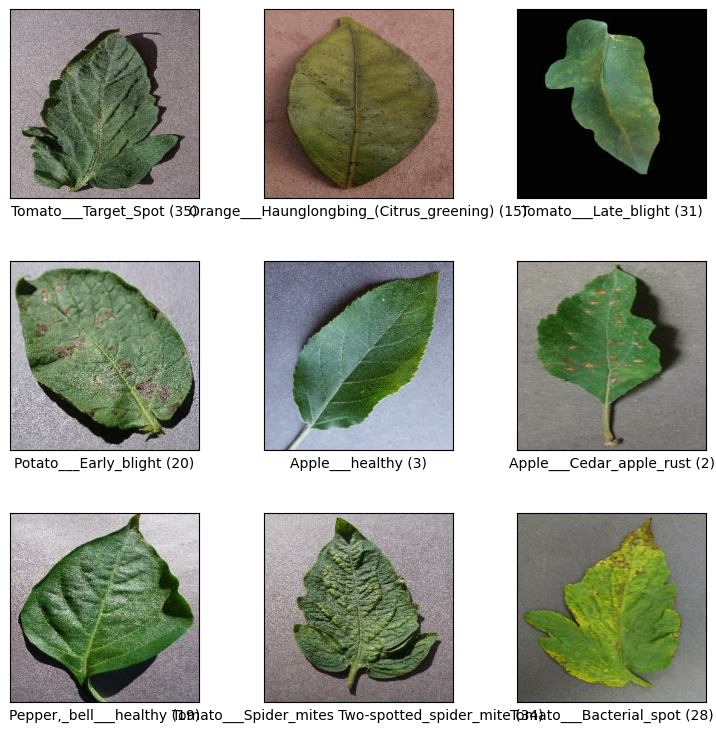

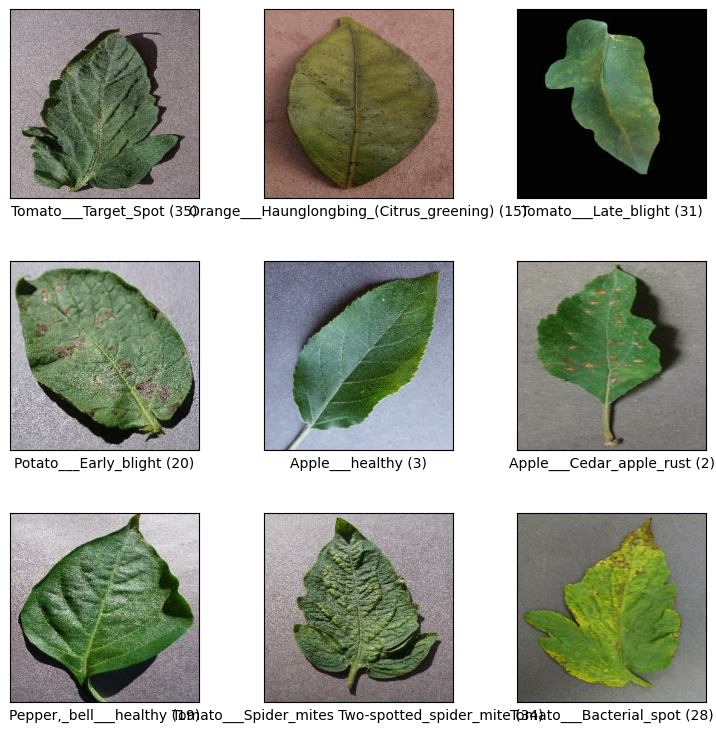

In [4]:
# Load the dataset for visualization
ds_train_visualize = tfds.load('plant_village', split=train_split, as_supervised=True)

# Display examples using the original dataset
tfds.show_examples(ds_train_visualize, ds_info)

In [5]:
# Define function for augmenting the training images
def augment(image, label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_flip_up_down(image)
  image = tf.image.random_brightness(image, max_delta=0.2)
  
  return image, label



In [6]:
# Apply the augs to the training set 

ds_train = ds_train.map(augment)

In [7]:
# Resize and normalise the dataset

def preprocess(image, label):
  image = tf.image.resize(image, (224, 224))
  image = tf.cast(image, tf.float32) / 255.0

  return image, label

In [8]:
# Apply preprocessing to train, test and val

ds_train = ds_train.map(preprocess)
ds_val = ds_val.map(preprocess)
ds_test = ds_test.map(preprocess)

In [9]:
# Batch and prefetch the datasets
batch_size = 32
ds_train = ds_train.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
ds_val = ds_val.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2S
import urllib.request

In [11]:
# instantiate the model

inception = InceptionV3(include_top = False,
                        weights = 'imagenet',
                        input_shape = (224,224, 3))

# Freeze the early feature layers

for layer in inception.layers:
  layer.trainable = False

#inception.summary()

87910968/87910968 [==============================] - 3s 0us/step


In [12]:
# Choose last pre-trained layer
inception_last_layer = inception.get_layer('mixed7')
print(('The output shape of last layer is: ', inception_last_layer.output_shape))
inception_last_output = inception_last_layer.output

('The output shape of last layer is: ', (None, 12, 12, 768))


In [29]:
# Add classification layers to the head of the Model
x = tf.keras.layers.GlobalAveragePooling2D()(inception_last_output)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(512, activation = 'relu')(x)
x = tf.keras.layers.Dense(38, activation = 'softmax', name = 'classification')(x)


In [30]:
model = Model(inception.input, x)

In [31]:
#Compile Model
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])



In [32]:
# model.summary()

In [33]:
history = model.fit(ds_train, epochs = 10, validation_data=ds_val, batch_size = 32)

Epoch 1/10
1188/1188 [==============================] - 113s 92ms/step - loss: 0.5719 - accuracy: 0.8323 - val_loss: 0.2450 - val_accuracy: 0.9153
Epoch 2/10
1188/1188 [==============================] - 109s 91ms/step - loss: 0.2184 - accuracy: 0.9269 - val_loss: 0.1577 - val_accuracy: 0.9461
Epoch 3/10
1188/1188 [==============================] - 107s 90ms/step - loss: 0.1705 - accuracy: 0.9420 - val_loss: 0.1540 - val_accuracy: 0.9434
Epoch 4/10
1188/1188 [==============================] - 100s 84ms/step - loss: 0.1481 - accuracy: 0.9488 - val_loss: 0.1160 - val_accuracy: 0.9599
Epoch 5/10
1188/1188 [==============================] - 107s 90ms/step - loss: 0.1329 - accuracy: 0.9544 - val_loss: 0.1148 - val_accuracy: 0.9575
Epoch 6/10
1188/1188 [==============================] - 106s 89ms/step - loss: 0.1169 - accuracy: 0.9592 - val_loss: 0.1286 - val_accuracy: 0.9519
Epoch 7/10
1188/1188 [==============================] - 99s 83ms/step - loss: 0.1075 - accuracy: 0.9622 - val_loss: 0.

In [34]:
loss, accuracy = model.evaluate(ds_test, batch_size = 32)

255/255 [==============================] - 15s 58ms/step - loss: 0.0903 - accuracy: 0.9694


In [35]:
print("Test loss : ", loss)
print("Test accuracy : ", accuracy)

Test loss :  0.09033206105232239
Test accuracy :  0.969429075717926


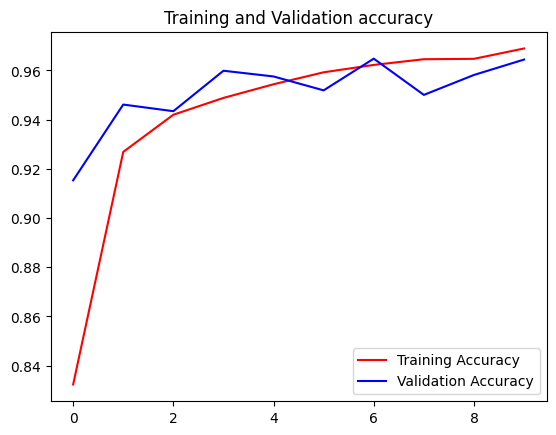

<Figure size 640x480 with 0 Axes>

In [36]:

# Plot training and val curves

acc = history.history['accuracy']
val_acc = history.history ['val_accuracy']
loss = history.history ['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label = "Training Accuracy")
plt.plot(epochs, val_acc, 'b', label = "Validation Accuracy")
plt.title('Training and Validation accuracy')
plt.legend(loc = 0)
plt.figure()

plt.show()

In [21]:
weights_filename = 'model_weights.h5'
model.save_weights(weights_filename)

In [22]:
from google.colab import files
files.download(weights_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
# Function to display test images

def display_images(images, predictions, true_labels, class_names, title, num_examples=6, num_cols = 2):
    num_rows = int(np.ceil(num_examples / num_cols))
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
    fig.suptitle(title)
    plt.subplots_adjust(hspace=0.5) 
    
    # Flatten the axes array for easier iteration
    axes = axes.flatten()
    
    for i in range(num_examples):
        axes[i].imshow(images[i])
        axes[i].set_title(f"True: {class_names[true_labels[i]]}\nPredicted: {class_names[predictions[i]]}")
        if true_labels[i] != predictions[i]:
            axes[i].set_title(axes[i].get_title(), color='red')
        axes[i].axis('off')
    
    plt.show()

In [38]:
# Extract test images and labels
num_examples = 20
test_images = []
test_labels = []

for image, label in ds_test.unbatch().take(num_examples):
    test_images.append(image.numpy())
    test_labels.append(label.numpy())


255/255 [==============================] - 15s 56ms/step


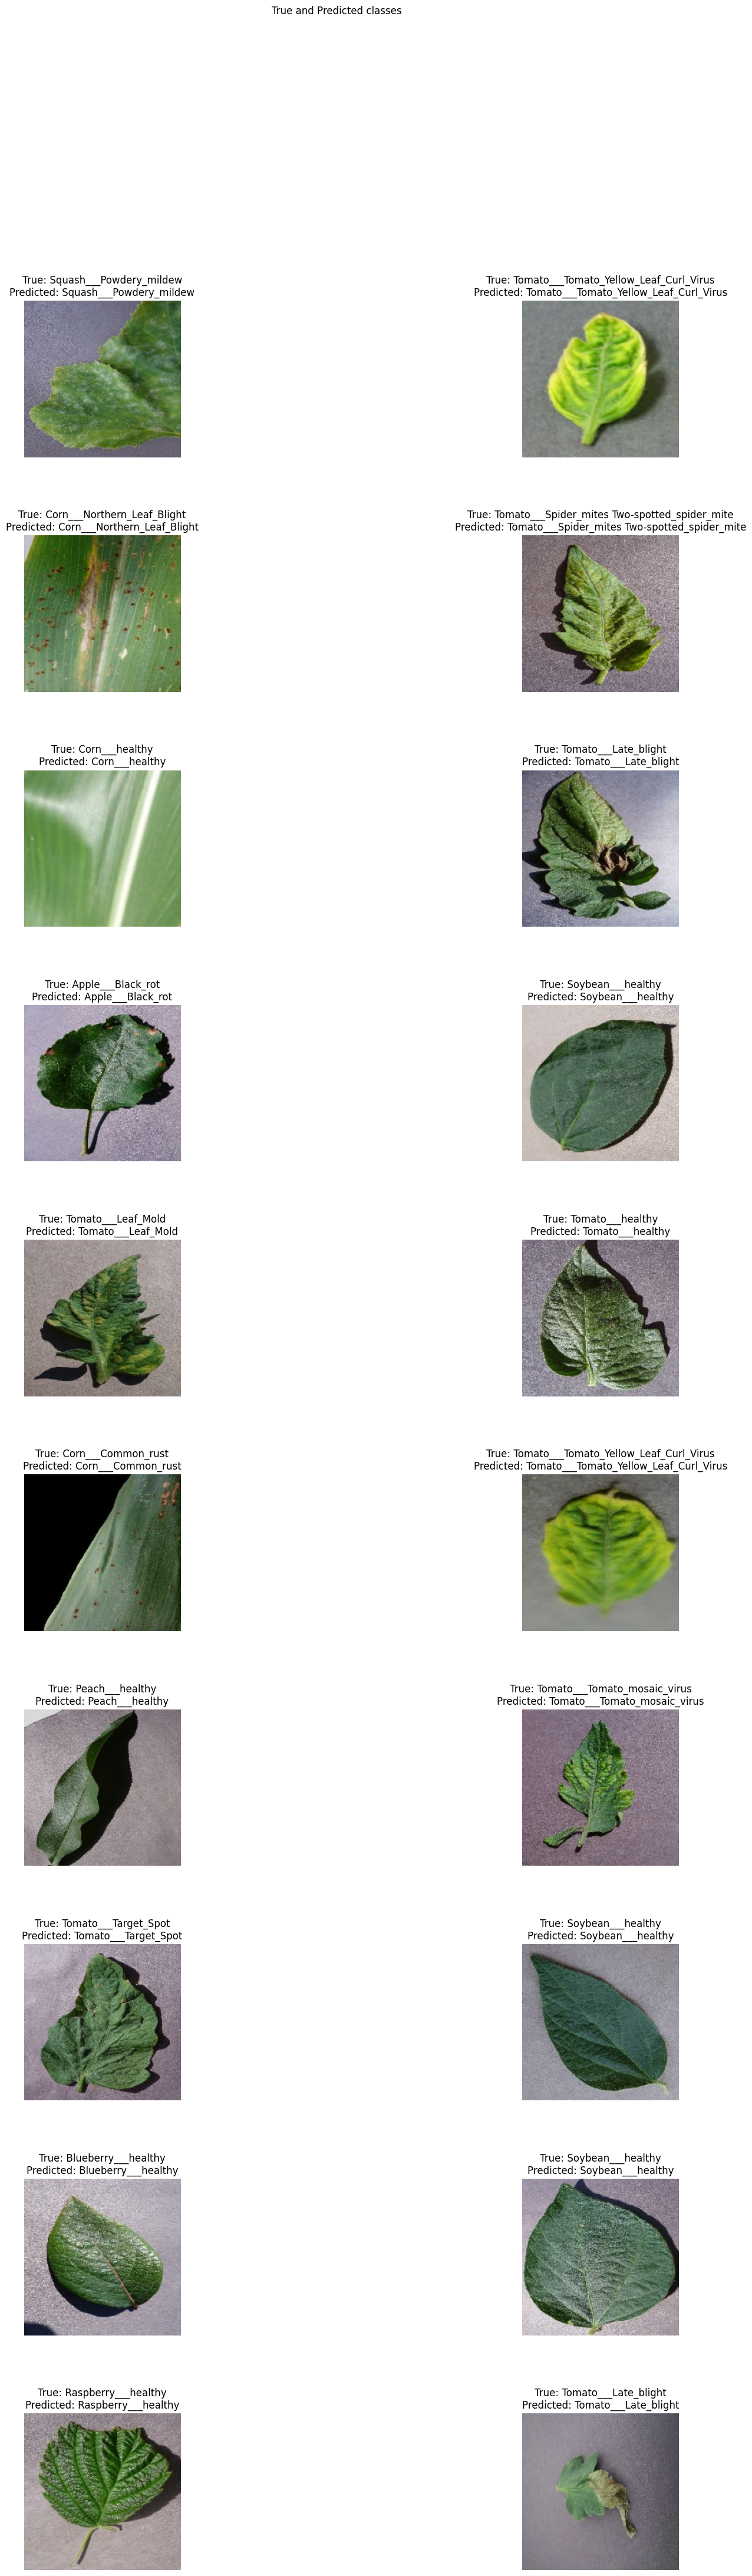

In [39]:
# Make predictions on test set
probabilities = model.predict(ds_test, batch_size=32)
predicted_labels = np.argmax(probabilities, axis=1)

# Display predictions
display_images(test_images, predicted_labels, test_labels, class_names, "True and Predicted classes", num_examples=num_examples)